# Completing the Circle, A Language for Thinking

### By Oliver Morris

Are programming languages half way to useful AI? In object orientated programming we specify a class to represent the attributes and methods of an object, then create instances from the class. In other words we start with a specification and create examples. But our human experience is often the reverse. Typically we are presented with many examples and attempt to generalise them into classes. Having done so, we apply our classes to simplify our world, then revise our understanding as our specifications are challenged. So, is there a case for a programming language capable of both halves of this circle between examples and classes?

Such a language could constantly adapt its classes to better meet some objective.

The simplest deep learning model which approximates this circle is the autoencoder. An encoder takes instances and attempts to compress them into a latent space, this is analogous to extracting a class specification from examples. A decoder is required in order to train the encoder in a differentiable manner. Usually the latent space represents attributes of an object, but it could equally be tasked with finding the most concise specification of an action (class method), to meet some outcome.

To repeat, the decoder is simply a differentiable manner of training the encoder. It would be preferable to use standard OOP to 'decode' the specification (latent space) into an instance. But such code would not be differentiable, requiring a reinforcement model as opposed to a straightforward neural network.

## Line Autoencoder

Let's take a simple example of this loop and explore how it might be built. Consider the drawing of a straight line, there's standard python code for that. But imagine if we had a model which could interpret such lines and arrange them into a new, more complex class. For example, shapes, or even a face. 

Trying to keep it simple, we would like to train an encoder which can deconstruct images of lines into their most compressed format, (start, end, width, colour etc). This is the latent space. We would lie to use the python line method, from the img class, as the decoder. That method reads the latent space (start, end, width, colour etc) and draws a line. This would then be compared with the image being entered to the encoder. A loss could be calculated and we'd proceed from there.

As stated, we can't use the img.line method in the model's code, because its not differentiable. However we know the 'latent space' for specifying a line to be drawn by the img.line method (start, end, width, colour etc). We can generate examples of those specifications and the images which the method would have drawn using them. We can then train a decoder to do the same job as the img.line method. Having trained the decoder, we can train an encoder.

## Long Term

Ultimately, we'd like a deep reasoning tool, which can take instances then:

    - hypothesise defining attributes (features)
    - using layers of those features, reduce the instances to their useful essence (latent space)
    - using that latent space, hypothesise a classification or rule about the object (not sure what the deep learning analogy is)
    - test those rules against further examples and adjust accordingly (train)

There are a large number of problems which fit this pattern. So let's explore how this toy problem yields to this approach.

## Data Generation

Step 1 is to train a decoder using a latent space which is usable by the img.line method. Then we can train an encoder to match.
The decoder will input line specifications and output images of lines, doing the same task the img.line method would.

img.line uses the following inputs:
('x_start', 'y_start'), ('x_end', 'y_end'), 'linecol', 'linewid', 'imgcolr'

We'll need some images of lines from which to train the decoder

In [1]:
#### IMPORTS

# file management
import os
import pickle

# math
import math  as math
import numpy as np
from random  import seed
from random  import randint

# data manipulation
import re
import pandas as pd

# ggplot in python, and matplot lib for some tasks
import plotnine as p9
import matplotlib.pyplot as plt

# deep learning
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras           import Model
from tensorflow.keras.layers    import Input, LeakyReLU, PReLU, Concatenate, Reshape, Flatten, Dense, Activation
from tensorflow.keras.layers    import Conv2D, MaxPool2D, UpSampling2D, Dropout, BatchNormalization, Add, ReLU
from tensorflow.keras.models    import load_model, save_model
from tensorflow.keras.utils     import plot_model

# image manipulation
from PIL import Image, ImageDraw
import cv2

In [3]:
# Set file location
proj_root  = 'D:\\Data\\ImageConcepts'
subfolders = ['Lines']

In [2]:
#### Confirm environment

print("Tensorflow Version:",               tf.__version__)
print("Is tensorflow executing eagerly? ", tf.executing_eagerly())
print("Is tensorflow using GPU? ",         tf.test.is_built_with_gpu_support())
print("Is tensorflow using Cuda? ",        tf.test.is_built_with_cuda())


Tensorflow Version: 2.1.0
Is tensorflow executing eagerly?  True
Is tensorflow using GPU?  True
Is tensorflow using Cuda?  True


In [ ]:
### Create Images of Lines ###

# We will need a function to add noise to the images of lines
# else the model can only handle perfect situations

def add_noise(img, var, w, h):
    
    # need to work in numpy format
    img = np.array(img)

    # set params for noise
    mean= 0
    sd  = var ** 0.5 

    # create noise
    noise = np.random.normal(loc=mean, scale=sd, size=(w, h)) #  np.zeros((w, h), np.float32)
    noisy_image = np.zeros(img.shape, np.float32)

    # apply noise
    if len(img.shape) == 2:
        # BW
        noisy_image = img + noise
    else:
        # RGB
        noisy_image[:, :, 0] = img[:, :, 0] + noise
        noisy_image[:, :, 1] = img[:, :, 1] + noise
        noisy_image[:, :, 2] = img[:, :, 2] + noise

    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    # format conversion
    # first round the values to integers by simply changing dtype
    noisy_img_npy = noisy_image.astype(np.uint8) 
    # those values can now be saved as an actual image
    noisy_img_pil = Image.fromarray(noisy_image.astype(np.uint8))
    # finally we need the integers in float format for Tensorflow
    noisy_img_npy = noisy_img_npy.astype(np.float)

    return noisy_img_pil, noisy_img_npy

In [ ]:
# CREATE TRAINING DATA. IMAGES OF LINES

# seed random number generator
seed(28042020)

shape_list= []
w, h = 64, 64

for i in range(0,10000):

    # get image params
    x_start = randint(0, w)
    y_start = randint(0, h)
    x_end   = randint(0, w)
    y_end   = randint(0, h)
    linecol = randint(0, 255)
    linewid = randint(1, 10)
    imgcolr = randint(0, 255)
    # we could use arcs instead of straight lines....
    # angstrt = randint(0, 10) # arc start angle, in degs
    # angends = randint(0, 10) # arc end angle, in degs

    # instantiate image
    # mode L is 8bit Greyscale
    # other modes at: https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes
    img  = Image.new(mode='L', size=(w, h), color=imgcolr) 
    draw = ImageDraw.Draw(img)

    # add line(s)
    shape = [(x_start, y_start), (x_end, y_end)] 
    draw.line(shape, fill=linecol, width=linewid) 

    # keep copy of clean image, no noise
    img_npy = np.array(img)

    # add random amount of noise to image
    var = np.random.normal(loc=0, scale=1, size=2) # loc=mean, scale=sd, size=height
    var = abs(var[0]) #+ve numbers only please.
    img_noisy_pil, img_noisy_npy = add_noise(img, var=var, w=w, h=h)

    # save to file
    filename = str(i).rjust(5, '0') + '.png'
    img_noisy_pil.save(os.path.join(proj_root, *subfolders, filename),"PNG")

    # we could use just one number to reference the start point 
    # and another number to represent the end point. 
    # This is done by imaging the pixels are each addresses with a single number, 
    # starting at 1,1, for the top left of the image
    # Therefore, two numbers are sufficient to record the start+end of the line.
    # Autoencoders are compression algorithms, so can seek the simplest representation
    get_pixel = lambda x,y,w,h : x+y*w
    pix_start = get_pixel(x_start, y_start, w, h)
    pix_end   = get_pixel(x_end,   y_end,   w, h)

    # save ALL line details to list
    shape_list.append(
        # filename    + x,y start      + x,y end
        [filename]    + list(shape[0]) + list(shape[1]) + 
        # pixel start + pixel end
        [pix_start]   + [pix_end]  +
        # line colour + line width + image colour
        [linecol]     + [linewid]  + [imgcolr] + 
        # npy version of image (with noise), numpy version of image (no noise)
        [img_noisy_npy] + [img_npy]
        )

# convert list of lists to pandas dataframe for convenience
# first 4 columns are easy....
shape_list_pd = pd.DataFrame(data   = [col[0:10] for col in shape_list], 
                             columns= ['filename', 'x_start', 'y_start', 'x_end', 'y_end', 'pix_start', 'pix_end', 'linecol', 'linewid', 'imgcolr'])

# final columns, the numpy arrays, are awkward due type conversion
shape_list_pd['img_noisy_npy'] = None
shape_list_pd['img_noisy_npy'] = shape_list_pd['img_noisy_npy'].astype('object')
shape_list_pd['img_noisy_npy'] = [col[10] for col in shape_list]

shape_list_pd['img_npy'] = None
shape_list_pd['img_npy'] = shape_list_pd['img_npy'].astype('object')
shape_list_pd['img_npy'] = [col[11] for col in shape_list]

# save data
# We'd like to use panda's to_csv()
# But, it adds '\n' into every row of the numpy arrays
# so we'll pickle the pandas object instead
shape_list_pd.to_pickle(os.path.join(proj_root, *subfolders, 'lineslist.pkl'))

# perhaps its useful to inspect the file, so let's save as csv as well...
shape_list_pd.to_csv(os.path.join(proj_root, *subfolders, 'lineslist.csv'), sep='\t')

In [4]:
# FUNCTIONS TO SELECT TRAIN, TEST AND VALIDATION DATASETS

# Load image data into training and testing data sets
shape_list_pd = pd.read_pickle(os.path.join(proj_root, *subfolders, 'lineslist.pkl'))

# proportions of data destined for train, test, validation
propns = [0.9,0.09,0.01]
rand_seqnc = np.random.rand(len(shape_list_pd))

train_mask = rand_seqnc < propns[0]
testi_mask = [True if rand > propns[0] and rand < (propns[0] + propns[1]) else False for rand in rand_seqnc]
valid_mask = rand_seqnc > (propns[0]+propns[1])

# prepare to standardise the data for the sake of better neural network weights
# For this we need mean and sd of the image data:
img_noisy_npy = np.stack(shape_list_pd['img_noisy_npy'], axis=0)

mn_img = np.mean(img_noisy_npy)
sd_img = np.std(img_noisy_npy)

# As an alternative to standardising the data we may range_shift it
# This requries us to have the min and range

mins_img  = 0   # min is zero for images
pk2pk_img = 255 # range is 0 to 255 for images

del img_noisy_npy

In [5]:
# and mean and sd of the latents (line specification)
# Get y (latent space) targets in numpy format
def get_latent_tgt(df):
    y_latent = df[['x_start', 'y_start', 'x_end', 'y_end', 'linecol', 'linewid', 'imgcolr']]
    y_latent = y_latent.to_numpy().astype('float32')
    return y_latent

latents_npy = get_latent_tgt(shape_list_pd)

mn_ltn = np.mean(latents_npy, axis=0)
sd_ltn = np.std(latents_npy, axis=0)

# As an alternative to standardising the data we may range_shift it
# This requries us to have the min and range
mins_ltn  = 0   # min is zero for all fields
pk2pk_ltn = np.ptp(latents_npy, axis=0) # range is different for all fields

# delete memory hungry dataframes..
del latents_npy

In [6]:
# FUNCTIONS FOR STANDARDISING DATA

def standardise(array_np, mn, sd):
    # ensure mn and sd are in numpy array format
    mn = mn if type(mn)==np.array else np.array([mn])
    sd = sd if type(sd)==np.array else np.array([sd])

    # standardise
    array_np = (array_np - mn) / sd

    return array_np

def de_standardise(array_np, mn, sd):
    # ensure mn and sd are in numpy array format
    mn = mn if type(mn)==np.array else np.array([mn])
    sd = sd if type(sd)==np.array else np.array([sd])

    # reverse standardisation
    array_np = (array_np * sd) + mn

    # if array is an image, eg stack of numpy arrays,
    # then convert to uint8, else leave as float32
    if len(array_np.shape) > 2:
        array_np = array_np.astype(np.uint8)

    return array_np

In [7]:
# Alternative to standardising the data is to shift the data into the range 0 to 1, or, -1 to 1
# Best for use with sigmoid or tanh activation respectively

def range_shift(array_np, mins=None, pk2pk=None):

    # handle zero length array
    if array_np.shape[0] == 0:
        mins  = np.array([])
        pk2pk = np.array([])

    else:
        array_np = (array_np - mins) / pk2pk

    return array_np

def de_range_shift(array_np, mins=None, pk2pk=None):

    # handle zero length array
    if array_np.shape[0] == 0:
        mins  = np.array([])
        pk2pk = np.array([])

    else:      
        array_np = (array_np * pk2pk) + mins

    return array_np


In [8]:

# Whichever activation is used, we still need to shuffle the data
# and get pandas file for train, test and validation

def get_sample(shape_list_pd, mask, method):

    assert method in ['standardise', 'range_shift'], 'ERROR: Data Processing Method Unknown'

    # if mask is entirely false (propn = 0.0) then return blanks
    if sum(mask) == 0:
        subset_pd = shape_list_pd.head(0)
        return subset_pd, np.array([]), np.array([]), np.array([])

    # filter samples using the mask, reset index
    subset_pd = shape_list_pd[mask].reset_index(drop=True)

    # The above line returns a pandas table but tensorflow will need
    # numpy formatted data for the image arrays
    # first we get the noisy version of the training data
    ipt_noisy_np = subset_pd['img_noisy_npy']

    # next we get the clean image
    ipt_clean_np = subset_pd['img_npy']

    # finally, the latents
    ipt_latents  = get_latent_tgt(subset_pd)

    # The image samples must be presented as a stack of numpy arrays
    ipt_noisy_np = np.stack(ipt_noisy_np, axis=0)
    ipt_clean_np = np.stack(ipt_clean_np, axis=0)
    
    # transform the data, for better neural net performance
    if method == 'standardise':
        ipt_noisy_np = standardise(ipt_noisy_np, mn=mn_img, sd=sd_img)
        ipt_clean_np = standardise(ipt_clean_np, mn=mn_img, sd=sd_img)
        ipt_latents  = standardise(ipt_latents,  mn=mn_ltn, sd=sd_ltn)
    else : # must be range_shift
        ipt_noisy_np = range_shift(ipt_noisy_np, mins=mins_img, pk2pk=pk2pk_img)
        ipt_clean_np = range_shift(ipt_clean_np, mins=mins_img, pk2pk=pk2pk_img)
        ipt_latents  = range_shift(ipt_latents,  mins=mins_ltn, pk2pk=pk2pk_ltn)

    # Now we have dims = (samples, w, h). We need (samples, w, h, channels)
    # Channels = 1 for BW images. For RGB images channels = 3
    # then we need to use expand_dims to get channels = 1 (samples, w, h, channels)
    ipt_noisy_np = np.expand_dims(ipt_noisy_np, axis=3)
    ipt_clean_np = np.expand_dims(ipt_clean_np, axis=3)

    return subset_pd, ipt_noisy_np, ipt_clean_np, ipt_latents

In [9]:
### APPLY TRAINING SET FUNCTIONS

# choose transform method
method = 'range_shift' # choice is 'standardise', 'range_shift'

train_pd, train_nsy, train_cln, train_ltn = get_sample(shape_list_pd, train_mask, method=method)
testi_pd, testi_nsy, testi_cln, testi_ltn = get_sample(shape_list_pd, testi_mask, method=method)
valid_pd, valid_nsy, valid_cln, valid_ltn = get_sample(shape_list_pd, valid_mask, method=method)

# confirm correct shape: (samples, w, h, channels)
def print_shapes(set_name, ipt, tgt, ltn):
    print(set_name)
    print('Noisy image shape : ', ipt.shape)
    print('Clean image shape : ', tgt.shape)
    print('Latents shape     : ', ltn.shape)
    print('\n')

print('Shape = (samples, w, h, channels)')
print_shapes('Train', train_nsy, train_cln, train_ltn)
print_shapes('Test',  testi_nsy, testi_cln, testi_ltn)
print_shapes('Valid', valid_nsy, valid_cln, valid_ltn) 


Shape = (samples, w, h, channels)
Train
Noisy image shape :  (90004, 64, 64, 1)
Clean image shape :  (90004, 64, 64, 1)
Latents shape     :  (90004, 7)


Test
Noisy image shape :  (8956, 64, 64, 1)
Clean image shape :  (8956, 64, 64, 1)
Latents shape     :  (8956, 7)


Valid
Noisy image shape :  (1040, 64, 64, 1)
Clean image shape :  (1040, 64, 64, 1)
Latents shape     :  (1040, 7)




# ENCODER MODEL BUILDING

Although we will train the decoder first, separately to the encoder, we will specify the encoder first. This is simply because autoencoder's are traditionally built with encoder first. 

The architecture will be a fairly standard set of blocks. Each block comprised of Conv2D, BatchNorm, Skip layer, MaxPool. The skip layers connects each block to the input to the prior block. There will then be four dense layers which output into the latent space.


In [10]:
class encoder_line(tf.keras.Model):

    def __init__(self, params_dict, name, **kwargs):

        super(encoder_line, self).__init__(name=name, **kwargs)

        # Get params
        self.filters       = params_dict.get('filters')    # is list, not single item
        self.dense_dims    = params_dict.get('dense_dims') # is list, not single item
        self.kernel_size   = params_dict.get('kernel_size')
        self.kinit         = params_dict.get('kinit')
        self.leaky_alpha   = params_dict.get('leaky_alpha')
        self.fnl_activation= params_dict.get('fnl_activation')

        # Specify layers (channels last)
        # Conv2D inputs  = (samples, rows, cols, channels)
        # Conv2D outputs = (samples, new_rows, new_cols, filters)

        # first conv block
        self.conv1    = Conv2D(filters=self.filters[0], kernel_size=3, kernel_initializer=self.kinit, padding='same', activation=None)
        self.batnm1   = BatchNormalization(axis=3)
        # SKIP PATH. Bridge the MaxPool, similar to residual block
        # feed original inputs to skip1. Hence filters =1, (no changes in channels) and strides = 2, so downsamples to same size as MaxPool
        # this layer ensures same dims as outputs from pool1
        self.skip1    = Conv2D(filters=1, kernel_size=1, strides=2, kernel_initializer=self.kinit, padding='same', activation=None)
        self.conv1lky = PReLU(alpha_initializer='zeros')
        self.pool1    = MaxPool2D((2,2))
        
        # next conv block
        self.conv2    = Conv2D(filters=self.filters[1], kernel_size=3, kernel_initializer=self.kinit, padding='same', activation=None)
        self.batnm2   = BatchNormalization(axis=3)
        self.add1     = Add() #([x, skip1])
        self.conv2lky = PReLU(alpha_initializer='zeros')
        # SKIP PATH. Bridge the MaxPool, similar to residual block
        # feed original inputs to skip1. Hence filters =1, (no changes in channels) and strides = 2, so downsamples to same size as MaxPool
        # this layer ensures same dims as outputs from pool1
        self.skip2    = Conv2D(filters=1, kernel_size=1, strides=2, kernel_initializer=self.kinit, padding='same', activation=None)
        self.pool2    = MaxPool2D((2,2))

        # next conv block
        self.conv3    = Conv2D(filters=self.filters[2], kernel_size=3, kernel_initializer=self.kinit, padding='same', activation=None)
        self.batnm3   = BatchNormalization(axis=3)
        self.add2     = Add() #([x, skip2])
        self.conv3lky = PReLU(alpha_initializer='zeros')
        self.pool3    = MaxPool2D((2,2))
        #self.dropout1 = Dropout(self.keep_propn)
        self.flatten  = Flatten()

        self.dense1   = Dense(self.dense_dims[0], kernel_initializer=self.kinit, activation=None)
        self.dense1lky= PReLU(alpha_initializer='zeros')

        self.dense2   = Dense(self.dense_dims[1], kernel_initializer=self.kinit, activation=None)
        self.dense2lky= PReLU(alpha_initializer='zeros')

        self.dense3   = Dense(self.dense_dims[2], kernel_initializer=self.kinit, activation=None)
        self.dense3lky= PReLU(alpha_initializer='zeros')

        self.dense4   = Dense(self.dense_dims[3], kernel_initializer=self.kinit, activation='linear')

    # we need this in order to call model.summary()
    # does not need to be a tf function
    # @tf.function
    def build_graph(self, input_shape): 
        input_shape_nobatch = input_shape[1:]
        self.build(input_shape)
        inputs = tf.keras.Input(shape=input_shape_nobatch)
 
        if not hasattr(self, 'call'):
            raise AttributeError("Must define 'call' method for class")
        
        _ = self.call(inputs, training=True)

    # make model serializable
    def get_config(self):
        return {'units': self.units}

    def call(self, inputs, training=None):
        # Define forward pass here,
        # 'training' is applicable to BatchNorm and DropOut
        # eg self.dropout(x, training=training)
        # keras.fit would normally do this, but we're using gradient tape
        # Uses layers previously defined (in `__init__`).

        # first conv block
        x = self.conv1(inputs)
        if training : x = self.batnm1(x)
        x = self.conv1lky(x)
        s = self.skip1(x)
        x = self.pool1(x)

        # next conv block
        x = self.conv2(x)
        if training : x = self.batnm2(x)
        x = self.add1([x, s])
        x = self.conv2lky(x)
        s = self.skip2(x)
        x = self.pool2(x)

        # next conv block
        x = self.conv3(x)
        if training : x = self.batnm3(x)
        x = self.add2([x, s])
        x = self.conv3lky(x)
        x = self.pool3(x)

        x = self.flatten(x)

        # logic blocks
        x = self.dense1(x)
        x = self.dense1lky(x)

        x = self.dense2(x)
        x = self.dense2lky(x)

        x = self.dense3(x)
        x = self.dense3lky(x)

        x = self.dense4(x)

        return x

## TEST ENCODER

Latent space size: = 7. These are the features required to specify a line:
    
    pix_start_x, pix_start_y, 
    pix_end_x,   pix_end_y, 
    linewid, linecol, imgcol


In [11]:
latent_dims = 7

# set params
params_dict_enc =  { 
                'kernel_size'   : 3,
                'filters'       : [32, 16, 8],  # filter sizes for TWO convolutional layers
                'keep_propn'    : 0.9,          # proportion kept in dropout, if applied
                'kinit'         : 'he_uniform', # alternatives: glorot_uniform, he_uniform etc
                'dense_dims'    : [256, 64, 16, latent_dims],    # node sizes for dense layers
                'fnl_activation': 'linear'
                }

# Instantiate the new model class
encoder_test = encoder_line(name='encoder_test', params_dict=params_dict_enc)
encoder_test.layers
# Execute the model on the example data (may submit numpy array or tensor)
encoder_test_output = encoder_test( train_cln[0:5,:,:,:] )

# Is the output shape right? 
print("Expecting encoder output shape: (samples, latent_space_dims)")
print("Actual encoder output shape   :  ", encoder_test_output.shape)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Expecting encoder output shape: (samples, latent_space_dims)
Actual encoder output shape   :   (5, 7)


In [12]:
# VIEW SUMMARY OF ENCODER
encoder_test.build_graph(input_shape=(None, 64, 64, 1))
encoder_test.summary()

Model: "encoder_test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 1)         33        
_________________________________________________________________
p_re_lu (PReLU)              (None, 64, 64, 32)        131072    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        4624      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)       

## DECODER

The decoder is constructed using fairly standard architecture. The latent space is read into a block of three dense layers, which then feed into convolutional blocks. Each block consists of UpSampling, Conv2D, BatchNorm. The output is the line image that the img.line method would have given for those latent space variables.



In [13]:
### DECODER MODEL BUILDING

class decoder_line(tf.keras.Model):
    def __init__(self, params_dict, name, **kwargs):
        super(decoder_line, self).__init__(name=name, **kwargs)

        # Get params
        self.filters       = params_dict.get('filters')    # is list, not single item
        self.dense_dims    = params_dict.get('dense_dims') # is list, not single item
        self.kernel_size   = params_dict.get('kernel_size')
        self.kinit         = params_dict.get('kinit')
        self.leaky_alpha   = params_dict.get('leaky_alpha')
        self.fnl_activation= params_dict.get('fnl_activation')
        self.relu_max_val  = params_dict.get('relu_max_val')
        self.reshaped_dim  = int( tf.math.pow(float(self.dense_dims[-1]),1.0/3.0) ) # cube root
        #self.keep_propn   = params_dict.get('keep_propn')

        if self.fnl_activation == 'relu':
            self.fnl_activation_txt = None
            self.relumax  = ReLU(max_value=self.relu_max_val, negative_slope=0.0, threshold=0.0)
        else:
            self.fnl_activation_txt = fnl_activation

        # Specify layers
        # Dense inputs   = (samples, latent_space_dims)

        self.dense1   = Dense(self.dense_dims[0], kernel_initializer=self.kinit, activation=None)
        self.dense1lky= PReLU(alpha_initializer='zeros') # LeakyReLU(alpha=self.leaky_alpha)

        self.dense2   = Dense(self.dense_dims[1], kernel_initializer=self.kinit, activation=None)
        self.dense2lky= PReLU(alpha_initializer='zeros') # LeakyReLU(alpha=self.leaky_alpha)

        self.dense3   = Dense(self.dense_dims[-1], kernel_initializer=self.kinit, activation=None)
        self.dense3lky= PReLU(alpha_initializer='zeros') # LeakyReLU(alpha=self.leaky_alpha)

        # Reshape (samples, rows, cols, channels)
        # samples (first dim) is implied
        # rows = cols = pow(dense_dims[2])-1/3 , ie cube root
        # channels = 1
        self.reshape1 = Reshape( (self.reshaped_dim, self.reshaped_dim, self.reshaped_dim) )

        self.upsample1= UpSampling2D((2,2))
        self.conv1    = Conv2D(filters=self.filters[0], kernel_size=3, kernel_initializer=self.kinit, padding='same', activation=None)
        self.batnm1   = BatchNormalization(axis=3)
        self.conv1lky = PReLU(alpha_initializer='zeros') # LeakyReLU(alpha=self.leaky_alpha)

        self.upsample2= UpSampling2D((2,2))
        self.conv2    = Conv2D(filters=self.filters[1], kernel_size=3, kernel_initializer=self.kinit, padding='same', activation=None)
        self.batnm2   = BatchNormalization(axis=3)
        self.conv2lky = PReLU(alpha_initializer='zeros') # LeakyReLU(alpha=self.leaky_alpha)

        self.upsample3= UpSampling2D((2,2))
        self.conv3    = Conv2D(filters=self.filters[2], kernel_size=3, kernel_initializer=self.kinit, padding='same', activation=self.fnl_activation_txt)

    # we need this in order to call model.summary()
    # does not need to be a tf function
    # @tf.function
    def build_graph(self, input_shape): 
        input_shape_nobatch = input_shape[1:]
        self.build(input_shape)
        inputs = tf.keras.Input(shape=input_shape_nobatch)
 
        if not hasattr(self, 'call'):
            raise AttributeError("Must define 'call' method for class")
        
        _ = self.call(inputs)

    def call(self, inputs, training=None):
        # Define forward pass here,
        # 'training' is applicable to BatchNorm and DropOut
        # eg self.dropout(x, training=training)
        # keras.fit would normally do this, but we're using gradient tape
        # Uses layers previously defined (in `__init__`).
        
        x = self.dense1(inputs)
        x = self.dense1lky(x)

        x = self.dense2(x)
        x = self.dense2lky(x)
        
        x = self.dense3(x)
        x = self.dense3lky(x)

        x = self.reshape1(x)

        x = self.upsample1(x)
        x = self.conv1(x)
        x = self.batnm1(x)
        x = self.conv1lky(x)
        
        x = self.upsample2(x)
        x = self.conv2(x)
        x = self.batnm2(x)
        x = self.conv2lky(x)

        x = self.upsample3(x)
        x = self.conv3(x)

        if self.fnl_activation == 'relu':
            x = self.relumax(x)

        return x
        

In [14]:

### TEST DECODER

# variety of choices for final activation; relumax, sigmoid, tanh
# These affect architecture of model
relu_max_val = np.max(train_cln)

# set params
params_dict_dec = {
                'kernel_size'   : 3,
                'filters'       : [32, 16, 1],     # filter sizes for THREE convolutional layers. Penultimate is always half of 64. Final is always 1 for BW image
                'kinit'         : 'glorot_normal', # alternatives: glorot_uniform, he_uniform etc
                'leaky_alpha'   : 0.2,             # if zero, then applies ReLu activation
                'dense_dims'    : [latent_dims, 256, 512],    # node qty for each dense layer. Final must be a square of an integer
                'fnl_activation': 'relu',
                'relu_max_val'  : relu_max_val*2
                }

# Instantiate the new model class
decoder_test = decoder_line(name='decoder_test', params_dict=params_dict_dec)

# Execute the model on the example data
decoder_test_output = decoder_test( encoder_test_output )

# Is the output shape right?
print("Expecting decoder output shape: (samples, w, h, channels)")
print("Actual decoder output shape   :  ", decoder_test_output.shape)

Expecting decoder output shape: (samples, w, h, channels)
Actual decoder output shape   :   (5, 64, 64, 1)


In [15]:

# VIEW SUMMARY OF DECODER
decoder_test.build_graph(input_shape=(None, latent_dims))
decoder_test.summary()


Model: "decoder_test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
re_lu (ReLU)                 (None, 64, 64, 1)         0         
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 56        
_________________________________________________________________
p_re_lu_6 (PReLU)            (None, 7)                 7         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2048      
_________________________________________________________________
p_re_lu_7 (PReLU)            (None, 256)               256       
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
p_re_lu_8 (PReLU)            (None, 512)              

## Comparing Output with Image.Draw

When inspecting the output images from the decoder we'll want to compare them to what the Image.Draw method would have done with the same latent variables. Here's the funciton for that:


In [16]:
# Function to convert line specification into a line image
# Required for visually displaying results of training

w, h = (64, 64)

def reconstruct_lines(latents_batch_tensor, unscale_data=False, w=w, h=h, mn=None, sd=None, pk2pk=255, mins=0):
    print("reconstruct_lines started")
    # convert to numpy
    latents_np = np.array(latents_batch_tensor)
    
    if unscale_data:
        if method == 'standardise':
            # de-standardise (start, end, width, colour, etc)
            latents_np = de_standardise(array_np=array_np, mn=mn, sd=sd)
        elif method == 'range_shift':
            # return range to normal
            latents_np = de_range_shift(array_np=latents_np, mins=mins, pk2pk=pk2pk)
        else:
            print("ERROR: Data processing method unkown")
            return AssertionError

    # get batch size
    batch_size = latents_np.shape[0]

    # initialise list for ouput, will convert to numpy later.
    reconst_np = []
    # reconst_ls = [] # list for images, not numpies.

    for i in range(batch_size):

        # ensure data is clipped to range 0-255 and is integer
        latents_ls = (np.clip(latents_np[1,:], a_min=0, a_max=255)).tolist()
        latents_ls = [int(a) for a in latents_ls]

        # separate out the features
        x_start, y_start, x_end, y_end, linecol, linewid, imgcolr = latents_ls

        # instantiate image. NB mode 'L' is 8bit Greyscale
        img  = Image.new(mode='L', size=(w, h), color=imgcolr)
        draw = ImageDraw.Draw(img)

        # add line(s)
        shape = [(x_start, y_start), (x_end, y_end)]
        draw.line(shape, fill=linecol, width=linewid)

        # expand dims so we have a channel dim
        img_np = np.expand_dims(np.array(img), axis=-1)

        # add to list of images
        reconst_np.append(img_np)
        # reconst_ls.append(img)
    
    # convert list of numpys into a numpy stack
    reconst_np = np.stack(reconst_np, axis=0)  

    return reconst_np # ,reconst_ls

## Helper Functions for Decoder Training

We'll need the following helper functions to train the decoder:
- Loss function
- Batch fetcher
- Save Model


In [18]:
# For the loss_object we could use a number of loss functions, most commonly:
# tf.keras.losses.mean_squared_error
# OR, SSIM, which is optimised for images:

def SSIM_loss(y_true, y_pred):
    # Note, ssim returns +1 when perfect match, -1 when perfectly opposite
    # So, we multiply by -1 to return a 'loss' which can be minimised.
    return tf.image.ssim(img1=y_true, img2=y_pred, max_val=2.25, 
                         filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)*-1.0

In [19]:
## Random Batch Fetcher

# akin to keras's shuffle when using keras.fit
# which we can't use cos we're using gradient tape.
def get_batch_mask(dataset_np, batch_size):
    
    # samples in dataset
    sample_max = dataset_np.shape[0]
    # randomly select next batch
    sample_ids = np.random.randint(low = 0, high = sample_max, size = batch_size) 

    return sample_ids

In [22]:
# Test SSIM loss function on Decoder

test_mask   = get_batch_mask(testi_ltn, batch_size=5)
test_x      = testi_ltn[test_mask,...]
test_y_true = tf.convert_to_tensor(testi_cln[test_mask,...], dtype=tf.float32)
test_y_pred = decoder_test(test_x)
loss_batch  = SSIM_loss(y_true=test_y_true, y_pred=test_y_pred)

print("Expect loss shape = (5,)")
print("Actual loss shape =", loss_batch.shape)

Expect loss shape = (5,)
Actual loss shape = (5,)


In [32]:
## Save Model Function

subfolders = ['Line_SaveModels']
filename   = 'model_line_DecodeByClass'

from contextlib import redirect_stdout

def save_model_custom(model_object, proj_root=proj_root, subfolders=subfolders, filename=filename):
    
    # save keras model (ie serialize and send to file)
    # Saving the model to HDF5 format does not work for subclassed models, 
    # because such models are defined via the body of a Python method, which isn't safely serializable. 
    # COMMENTED OUT
    # model_object.save(os.path.join(proj_root,model_root,filename+'_model.h5'), save_format='tf')

    # save weights
    model_object.save_weights(os.path.join(proj_root, *subfolders, filename+'_weights.tf'))

    # save summary text
    filename_txt = os.path.join(proj_root, *subfolders, filename+'_summary.txt')
    with open(filename_txt, 'w') as f:
        with redirect_stdout(f):
            model_object.summary()
    
    # save graph image
    # COMMENTED OUT
    # plot_model does not work properly for subclassed models either. Hence commented out
    # filename_png = os.path.join(proj_root,model_root,filename+'_graph.png')
    # plot_model(model_object, to_file=os.path.join(proj_root,model_root,filename_png), show_shapes=True)
 

## TRAINING FUNCTION

We will create our own training function, as opposed to use keras.fit(). This gives a little more control should we need it.

One function will be created which can train the decoder, the encoder or an entire autoencoder. The function will allow for each component to be trained separately, together or with one component having fixed weights whilst the other is trainable.

Beware this is a gradient tape training loop set to 'persistent' 
   See intro to such loops at

   - https://www.tensorflow.org/tutorials/customization/autodiff

   - https://tensorflow.rstudio.com/tutorials/advanced/customization/autodiff/

   and potential hiccups at:

   - http://blog.ai.ovgu.de/posts/jens/2019/001_tf20_pitfalls/index.html
   


In [24]:
# first a function to calculate gradients for a model
      
def update_weights(train_model, tape, loss, optimizer):
    train_model_gradients = tape.gradient(loss, train_model.trainable_variables)
    grads_and_vars = list(zip(train_model_gradients, train_model.trainable_variables))
    optimizer.apply_gradients(grads_and_vars = grads_and_vars)


In [25]:
def train_model(  train_encoder,         # can be 'None' if training decoder only
                  train_decoder,         # can be 'None' if training encoder only
                  is_encoder_trainable,  # boolean, fixes weights as appropriate for training
                  is_decoder_trainable,  # boolean, fixes weights as appropriate for training
                  model_type,            # encoder only, decoder only, autoencoder (ie encoder+decoder)
                  train_x, 
                  train_y,
                  valid_x,
                  valid_y,        
                  batch_size, 
                  num_epochs, 
                  optimizer,
                  loss_object,
                  earlystop):

    assert model_type in ['encoder', 'decoder', 'autoencoder'], "Unknown Model Type. Must be in ['encoder', 'decoder', 'autoencoder']"

    # If autoencoding, then train_y = train_x
    if model_type == 'autoencoder':
        assert train_x.shape[0] > 0, "No training data"
        train_y = train_x
        valid_y = valid_x
    else:
        # else ensure we have both y and x, and that they are of equal length
        assert train_y.shape[0] == train_x.shape[0]
        assert valid_y.shape[0] == valid_x.shape[0]

    # set model trainability
    if type(train_encoder)==bool:
        train_encoder = set_model_trainability(model=train_encoder, is_trainable=is_encoder_trainable)

    if type(train_decoder)==bool:
        train_decoder = set_model_trainability(model=train_decoder, is_trainable=is_decoder_trainable)

    # calculate batches per epoch
    batches_per_epoch = math.ceil(len(train_x)/batch_size)

    # initialise loss params for each epoch
    batch_losses = []
    epoch_losses = []

    # loop over epochs
    for epoch in range(num_epochs):

        # loop over batches in a single epoch
        for batch_id in range(batches_per_epoch):
        
            # randomly sample next batch
            mask    = get_batch_mask(train_x, batch_size)
            x_batch = tf.convert_to_tensor(train_x[mask,...], dtype=tf.float32)
            y_true  = tf.convert_to_tensor(train_y[mask,...], dtype=tf.float32)

            # The forward pass is recorded by a GradientTape, 
            # and during the backward pass we explicitly calculate gradients 
            # of the loss with respect to the model’s weights. 
            # These weights are then adjusted by the optimizer.
            with tf.GradientTape(persistent=True) as tape: #, watch_accessed_variables=False
                # Automatically watch all trainable variables
                # tape.watch(x_batch)

            #### RECORD FORWARD PASS ###
                if model_type == 'autoencoder':
                    latent = train_encoder(x_batch)
                    y_pred = train_decoder(latent)

                elif model_type == 'encoder':
                    y_pred = train_encoder(x_batch)

                elif model_type == 'decoder':
                    y_pred = train_decoder(x_batch)
                else:
                    print('No such model type')
                    break

            ### CALCULATE LOSS ###
                loss = loss_object(y_true=y_true, y_pred=y_pred)

            # End of Gradient Tape, Forward prop has ended for the batch

            # record batch losses
            batch_losses.append([epoch, batch_id, float(tf.reduce_mean(loss))])

            # update encoder weights etc
            if train_encoder is not None and is_encoder_trainable:
                update_weights(train_model=train_encoder, tape=tape, loss=loss, optimizer=optimizer) 

            # update decoder weights etc
            if train_decoder is not None and is_decoder_trainable:
                update_weights(train_model=train_decoder, tape=tape, loss=loss, optimizer=optimizer)             

        # end of batch loop

        # record epoch losses for TRAINING data
        epoch_loss = sum([col[2] for col in batch_losses[-batches_per_epoch:]])/batches_per_epoch
        
        # record epoch losses for VALIDATION data
        if model_type == 'autoencoder':
            valid_latent = train_encoder(valid_x)
            valid_y_pred = train_decoder(valid_latent)
        elif model_type == 'encoder':
            valid_y_pred = train_encoder(valid_x)
        else : # must be decoder
            valid_y_pred = train_decoder(valid_x)
        
        epoch_loss_valid = float(tf.reduce_mean(loss_object(y_true=valid_y, y_pred=valid_y_pred)))

        # save both epoch losses to list
        epoch_losses.append([epoch, epoch_loss, epoch_loss_valid])

        # every few epochs print results to screen
        if epoch % 5 == 0 or epoch == num_epochs-1: #every fifth epoch

            # print losses to screen
            print( 'Epoch {}:'.format(epoch), ' loss_train: ', epoch_loss, ' loss_valid: ', epoch_loss_valid )

        # Early Stopping. cease training if too many epochs without progress
        # We can consider this if already done a certain number of epochs
        if epoch > earlystop:
            # what was the lowest loss prior to the last bunch of epochs?
            lowest_epoch_loss_prior  = min([col[1] for col in epoch_losses[:epoch-earlystop]])
            # what was the lowest loss in the last bunch of epochs
            lowest_epoch_loss_recent = min([col[1] for col in epoch_losses[-earlystop:]])
            # if the recent bunch can't beat what happened before, then break the loop
            if lowest_epoch_loss_recent > lowest_epoch_loss_prior:
                print("No progress. Applied early stopping at epoch = ", epoch)
                break

    # end of epoch loop
    del tape

    # convert training results to pandas for convenience
    epoch_losses_pd = pd.DataFrame(data=epoch_losses, columns=['epoch', 'loss_train', 'loss_valid'])

    return train_encoder, train_decoder, epoch_losses_pd


In [29]:
### SET UP MODEL, OPTIMISER, LOSS, ETC
### SET UP THE TRAINING LOOP

### Epochs & Batches
num_epochs = 10
batch_size = 100 # save as VAE for similar sample size reasons
earlystop  = 30  # epochs without progress which trigger early stopping of training

# The optimizer
optimizer  = tf.keras.optimizers.Adam(1e-4)

# instantiate model to be trained
decoder = decoder_line(name='decoder_line', params_dict=params_dict_dec)

# decoder loss function
loss_object = tf.keras.losses.mean_squared_error


In [30]:
# inspect decoder model layers

decoder.layers

In [33]:
# train decoder
_, decoder, epoch_losses_dec = train_model( train_encoder = None,
                                            train_decoder = decoder,
                                            model_type    = 'decoder',      # CHOICE: encoder, decoder, autoencoder (ie encoder+decoder)
                                            train_x       = train_ltn, 
                                            train_y       = train_cln,      # if training autoencoder then beware that y=x
                                            valid_x       = valid_ltn,
                                            valid_y       = valid_cln,      # if training autoencoder then beware that y=x
                                            batch_size    = batch_size, 
                                            num_epochs    = num_epochs, 
                                            optimizer     = optimizer,
                                            loss_object   = loss_object,
                                            earlystop     = earlystop,
                                            is_encoder_trainable = None,    # boolean, fixes weights as appropriate for training
                                            is_decoder_trainable = True)    # boolean, fixes weights as appropriate for training


Epoch 0:  loss_train:  0.04701102026774404  loss_valid:  0.010636638849973679
Epoch 5:  loss_train:  0.006563561837231279  loss_valid:  0.006796401459723711
Epoch 9:  loss_train:  0.006348709851042363  loss_valid:  0.006507398560643196


## Decoder Training Results

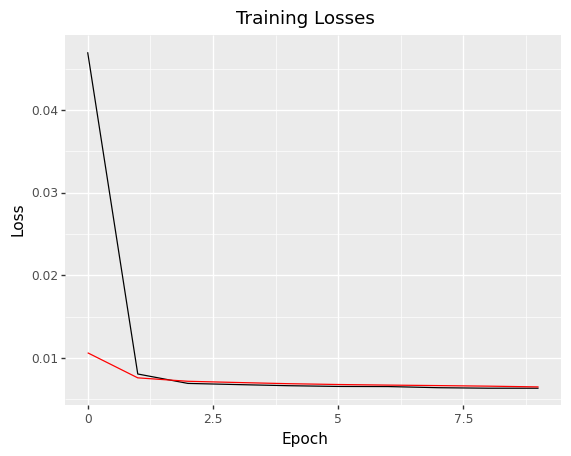

<ggplot: (-9223371933608425300)>

In [49]:
### CHART TRAINING HISTORY

# save training history to file
epoch_losses_dec.to_csv(os.path.join(proj_root, *subfolders, 'decoder_from_latents_epoch_history.csv'))

#plot training history
(p9.ggplot(data   = epoch_losses_dec,
           mapping= p9.aes(x='epoch'))
    + p9.geom_line(p9.aes(y='loss_train'), color='black')
    + p9.geom_line(p9.aes(y='loss_valid'), color='red')
    + p9.xlab('Epoch')
    + p9.ylab('Loss')
    + p9.ggtitle('Training Losses')
)

In [153]:
### SAVE DECODER

# Save encoder
filename = 'decoder_from_latents'
save_model_custom(model_object = decoder,
                  filename     = filename)



Let's compare the decoder's intrpretation of the latent space with what the Image.Draw method would have drawn with the same variables.
The below chart shows the trained decoder gives excelent results.

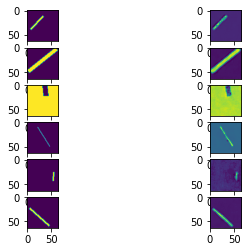

In [160]:
### INSPECT RECONSTRUCTIONS
# function to create list of images, original beside reconstruction
def get_table_of_images(imgs_np_x, imgs_np_r):
    
    #imgs_np_x for np array of ground truth images
    #imgs_np_r for np array of reconstructions

    assert len(imgs_np_x) == len(imgs_np_r), "Different length arrays."
    img_qty = len(imgs_np_x)
    img_lst = []

    fig,ax = plt.subplots(img_qty,2)

    for i in range(img_qty):
        img_x = Image.fromarray(imgs_np_x[i,:,:,0].astype(np.uint8))
        ax[i][0].imshow(img_x)
        img_r = Image.fromarray(imgs_np_r[i,:,:,0].astype(np.uint8))
        ax[i][1].imshow(img_r)
    
    fig.show()

mask        = get_batch_mask(testi_cln, batch_size=6)
x_test      = testi_ltn[mask,...]
y_test_true = testi_cln[mask,...]
y_test_pred = decoder(x_test).numpy()

# range shift, both y_true and y_pred must be returned to 0-255 range
y_test_true = de_range_shift(array_np=y_test_true, mins=mins_img, pk2pk=pk2pk_img)
y_test_pred = de_range_shift(array_np=y_test_pred, mins=mins_img, pk2pk=pk2pk_img)

# function to display above list of images
get_table_of_images(imgs_np_x=y_test_true, imgs_np_r=y_test_pred)

## Train the Encoder to Give Latents Required by Decoder

We now have a decoder which can take the specification of a line, its minimal representation, and draw the line image. This decoder replicates, in a differentiable manner, the line method of the Image class.

Of course, this is the component of the process which we can already do with normal code! Its simply useful that the decoder is differentiable whereas the line class is not.

The next step is to create an encoder which can compress any image into the required latents. We can then train this with the loss defined by either:
    a: the encoder's latents vs the true latents
    b: the autoencoder's output image vs the true input image (where autoencoder = encoder + fixed decoder)

We'll select option (b) because (a) is trivial and has been tried before, with limited success. Humans would judge the error not on the latents but on the images reulting from those latents.

The decoder will be fixed, ie weights not trainable, during this process

In [177]:
# We'll need to freeze and unfreeze the weights of each layer in a model

def set_model_trainability(model, is_trainable):
    # ensure we know what to do with our layers (set trainable = true or false)
    assert type(is_trainable)==bool, "Must state whether model is_trainable or not"
    # Set every layer to be non-trainable:
    for layer in model.layers:
        layer.trainable=is_trainable
    return model
    

In [ ]:
### Epochs & Batches
num_epochs = 500
batch_size = 100 # save as VAE for similar sample size reasons
earlystop  = 30  # epochs without progress which trigger early stopping of training

# The optimizer
optimizer  = tf.keras.optimizers.Adam(1e-4)

# instantiate model to be trained
encoder = encoder_line(name='encoder_line', params_dict=params_dict_enc)

# decoder loss function
loss_object = tf.keras.losses.mean_squared_error


In [ ]:
# instantiate model to be trained
decoder = decoder_line(name='decoder_line', params_dict=params_dict_dec)

decoder.load_weights('my_model_weights.h5')

In [ ]:
# train encoder
encoder, _, epoch_losses_enc = train_model( train_encoder = encoder,
                                            train_decoder = decoder,
                                            model_type    = 'autoencoder',  # CHOICE: encoder, decoder, autoencoder (ie encoder+decoder)
                                            train_x       = train_cln, 
                                            train_y       = None,           # y=x for autoencoder
                                            valid_x       = valid_cln,
                                            valid_y       = None,           # y=x for autoencoder    
                                            batch_size    = batch_size, 
                                            num_epochs    = num_epochs, 
                                            optimizer     = optimizer,
                                            loss_object   = loss_object,
                                            earlystop     = earlystop,
                                            is_encoder_trainable = True,    # boolean, fixes weights as appropriate for training
                                            is_decoder_trainable = False)   # boolean, fixes weights as appropriate for training
                                            

In [ ]:
### CHART TRAINING HISTORY

# save training history to file
epoch_losses_enc.to_csv(os.path.join(proj_root, *subfolders, 'encoder_epoch_history.csv'))

#plot traniing history
(p9.ggplot(data   = epoch_losses_enc,
           mapping= p9.aes(x='epoch',
                           y='loss'))
    + p9.geom_line()
)

In [ ]:
### SAVE MODELS

# Save encoder
filename = 'encoder'
save_model_custom(model_object = encoder,
                  filename     = filename)